# Part C

## Modelling over actual clusters' mass distribution

In [1]:
%pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from subprocess import run
import os
import mesa_reader
import multiprocessing as mp

In [3]:

def salpeter_imf(mass_min, mass_max, num_stars):
    """Generate masses following Salpeter IMF: dN/dM ∝ M^(-2.35)"""
    alpha = -2.35
    u = np.random.random(num_stars)
    alpha1 = alpha + 1
    m1 = mass_min**alpha1
    m2 = mass_max**alpha1
    masses = (m1 + (m2 - m1)*u)**(1/alpha1)
    return masses

In [4]:
def inlist_pgstar(mass):
    return f"""
&pgstar
  ! see star/defaults/pgstar.defaults

  ! MESA uses PGPLOT for live plotting and gives the user a tremendous
  ! amount of control of the presentation of the information.

  ! show HR diagram
  ! this plots the history of L,Teff over many timesteps

    TRho_Profile_win_width = 6
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_win_flag = .true.
    TRho_Profile_file_flag = .true.
    TRho_Profile_file_dir = 'pgstar_out_{mass}'
    TRho_Profile_file_prefix = 'trho_pgstar_{mass}'
    TRho_Profile_file_interval = 50
    TRho_Profile_win_width = 9
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_title = 'TRho'


  ! set static plot bounds
    HR_logT_min = 3.5
    HR_logT_max = 4.6
    HR_logL_min = 2.0
    HR_logL_max = 6.0

  ! set window size (aspect_ratio = height/width)
    HR_win_width = 6
    HR_win_aspect_ratio = 1.0
    HR_win_flag = .true.
    HR_file_flag = .true.
    HR_file_dir = 'pgstar_out_{mass}'
    HR_file_prefix = 'hr_pgstar_{mass}'
    HR_file_interval = 50
    HR_win_width = 9
    HR_win_aspect_ratio = 1.0
    HR_title = 'HR'



  ! show temperature/density profile
  ! this plots the internal structure at single timestep
    TRho_Profile_win_flag = .true.

  ! add legend explaining colors
    show_TRho_Profile_legend = .true.

  ! display numerical info about the star
    show_TRho_Profile_text_info = .true.

  ! set window size (aspect_ratio = height/width)
    TRho_Profile_win_width = 8
    TRho_Profile_win_aspect_ratio = 0.75

/ ! end of pgstar namelist
"""


def inlist_project(mass):
    return f"""
&star_job

    create_pre_main_sequence_model = .true.

    save_model_when_terminate = .false.
    save_model_filename = '15M_at_TAMS.mod'

    pgstar_flag = .true.

/ 


&kap
  use_Type2_opacities = .true.
  Zbase = 0.02

/

&controls
    initial_mass = {mass} ! in Msun units
    initial_z = 0.02

    Lnuc_div_L_zams_limit = 0.99d0
    stop_near_zams = .true.

    xa_central_lower_limit_species(1) = 'h1'
    xa_central_lower_limit(1) = 1d-3

     energy_eqn_option = 'dedt'
     use_gold_tolerances = .true.


/
"""

In [ ]:
mass_l_t = dict()
results = []

def run_mesa_model(masses):
    for mass in masses:
        """Run MESA for a single mass"""
        print(f"FOR MASS: {mass}")
        
        with open('star/inlist_pgstar', 'w') as f:
            f.write(inlist_pgstar(mass))
        
        with open('star/inlist_project', 'w') as f:
            f.write(inlist_project(mass))
        
        run(['pwd'], check=True)
        run(['ls'], check=True)
        os.chdir("./star")
        run(['pwd'], check=True)
        run(['./mk'], check=True)
        run(['./rn'], check=True)
        os.chdir("../")
        
        if os.path.exists('star/LOGS/history.data'):
            results.append({'mass': mass, 'success': True})
        else:
            results.append({'mass': mass, 'success': False})

        mr = mesa_reader.MesaData(file_name='./star/LOGS/history.data')
        mass_l_t[mass] = (mr.log_L, mr.log_Teff)



  

In [6]:
def plot_hr_diagram(masses):
    """Plot HR diagram for all stars in the same plot"""
    plt.figure()
    for mass in masses:
        plt.plot(mass_l_t[mass][1], mass_l_t[mass][0], label=f'{mass:.2f} Msun')
    plt.gca().invert_xaxis()
    plt.xlabel('log(Teff)')
    plt.ylabel('log(L)')
    plt.legend()
    plt.show()

## Cluster M44

FOR MASS: 0.8010592761709701
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
partC.ipynb
report.tex
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:01:17
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.618577   4078.688  -4.881376  -4.881376   0.801059   0.801059   0.700000   0.001010   0.280000  -3.650987    703      0
-4.8416E+00   6.618577   0.175738 -99.000000  -6.279070 -99.000000   0.000000   0.280000   0.009381   0.020000   0.082663      2
 3.6400E-05   0.316683  -0.251748 -99.000000 -99.000000  -6.608802   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.618577   4078.688  -4.881376  -4.881376   0.801059   0.801059   0.700000   0.001010   0.280000  -3.650987    703      0
-4.7625E+00   6.618577   0.175738 -99.000000  -6.279070 -99.000000   0.000000   0.280000   0.009381   0.020000   0.082663      2
 5.3680E-05   0.316683  -0.251748 -20.072100 -99.000000  -6.608802   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.618577   4078.688  -4.881376  -4.881376   0.801059   0.801059   0.700000   0.001010   0.280000  -3.650987    703      0
-4.6833E+00   6.618577   0.175738 -99.000000  -6.279070 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:04:51
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.602305   4576.395  -5.198174  -5.198174   1.156759   1.156759   0.700000   0.001010   0.280000  -4.436066    700      0
-4.8416E+00   6.602305   0.351047 -99.000000  -6.595966 -99.000000   0.000000   0.280000   0.009381   0.020000   0.064938      2
 3.6400E-05  -0.046565   0.298882 -99.000000 -99.000000  -6.944554   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.602305   4576.394  -5.198174  -5.198174   1.156759   1.156759   0.700000   0.001010   0.280000  -4.436066    700      0
-4.7625E+00   6.602305   0.351047 -99.000000  -6.595966 -99.000000   0.000000   0.280000   0.009381   0.020000   0.064938      2
 5.3680E-05  -0.046565   0.298881 -99.000000 -99.000000  -6.944554   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.602305   4576.393  -5.198174  -5.198174   1.156759   1.156759   0.700000   0.001010   0.280000  -4.436066    700      0
-4.6833E+00   6.602305   0.351047 -99.000000  -6.595966 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:09:02
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.556481   4866.077  -5.802718  -5.802718   1.626735   1.626735   0.700000   0.001010   0.280000  -5.271548    679      0
-4.8416E+00   6.556481   0.544919 -99.000000  -7.200557 -99.000000   0.000000   0.280000   0.009381   0.020000   0.051855      2
 3.6400E-05  -0.477174   0.793248 -99.000000 -99.000000  -7.130507   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.556481   4866.007  -5.802718  -5.802718   1.626735   1.626735   0.700000   0.001010   0.280000  -5.271548    679      0
-4.7625E+00   6.556481   0.544919 -99.000000  -7.200557 -99.000000   0.000000   0.280000   0.009381   0.020000   0.051855      2
 5.3680E-05  -0.477174   0.793223 -21.197038 -99.000000  -7.130498   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.556481   4865.958  -5.802718  -5.802718   1.626735   1.626735   0.700000   0.001010   0.280000  -5.271548    679      0
-4.6833E+00   6.556481   0.544919 -99.000000  -7.200557 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:12:59
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.628513   4000.051  -4.752742  -4.752742   0.758057   0.758057   0.700000   0.001010   0.280000  -3.497292    709      0
-4.8416E+00   6.628513   0.140878 -99.000000  -6.150403 -99.000000   0.000000   0.280000   0.009381   0.020000   0.085976      2
 3.6400E-05   0.397693  -0.355289 -19.867980 -99.000000  -6.533285   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.628513   4000.051  -4.752742  -4.752742   0.758057   0.758057   0.700000   0.001010   0.280000  -3.497292    709      0
-4.7625E+00   6.628513   0.140878 -99.000000  -6.150403 -99.000000   0.000000   0.280000   0.009381   0.020000   0.085976      2
 5.3680E-05   0.397693  -0.355289 -20.470040 -99.000000  -6.533285   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.628513   4000.051  -4.752742  -4.752742   0.758057   0.758057   0.700000   0.001010   0.280000  -3.497292    709      0
-4.6833E+00   6.628513   0.140878 -99.000000  -6.150403 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:16:59
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.569519   4829.896  -5.643569  -5.643569   1.531378   1.531378   0.700000   0.001010   0.280000  -5.104551    676      0
-4.8416E+00   6.569519   0.505400 -99.000000  -7.041401 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054001      2
 3.6400E-05  -0.385222   0.701245 -99.000000 -99.000000  -7.096624   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.569519   4829.864  -5.643569  -5.643569   1.531378   1.531378   0.700000   0.001010   0.280000  -5.104551    676      0
-4.7625E+00   6.569519   0.505400 -99.000000  -7.041401 -99.000000   0.000000   0.280000   0.009381   0.020000   0.054001      2
 5.3680E-05  -0.385222   0.701233 -99.000000 -99.000000  -7.096619   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.569519   4829.838  -5.643569  -5.643569   1.531378   1.531378   0.700000   0.001010   0.280000  -5.104551    676      0
-4.6833E+00   6.569519   0.505400 -99.000000  -7.041401 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:20:08
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.610829   4447.916  -5.069110  -5.069110   1.042831   1.042831   0.700000   0.001010   0.280000  -4.199677    702      0
-4.8416E+00   6.610829   0.297494 -99.000000  -6.466879 -99.000000   0.000000   0.280000   0.009381   0.020000   0.069551      2
 3.6400E-05   0.068413   0.142309 -99.000000 -99.000000  -6.868739   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.610829   4447.908  -5.069110  -5.069110   1.042831   1.042831   0.700000   0.001010   0.280000  -4.199677    702      0
-4.7625E+00   6.610829   0.297494 -99.000000  -6.466879 -99.000000   0.000000   0.280000   0.009381   0.020000   0.069551      2
 5.3680E-05   0.068413   0.142306 -99.000000 -99.000000  -6.868736   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.610829   4447.898  -5.069110  -5.069110   1.042831   1.042831   0.700000   0.001010   0.280000  -4.199677    702      0
-4.6833E+00   6.610829   0.297494 -99.000000  -6.466879 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:23:25
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.582152   4772.847  -5.483014  -5.483014   1.416325   1.416325   0.700000   0.001010   0.280000  -4.905121    680      0
-4.8416E+00   6.582152   0.458771 -99.000000  -6.880837 -99.000000   0.000000   0.280000   0.009381   0.020000   0.056871      2
 3.6400E-05  -0.279852   0.587346 -99.000000 -99.000000  -7.055266   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.582152   4772.850  -5.483014  -5.483014   1.416325   1.416325   0.700000   0.001010   0.280000  -4.905121    680      0
-4.7625E+00   6.582152   0.458771 -99.000000  -6.880837 -99.000000   0.000000   0.280000   0.009381   0.020000   0.056871      2
 5.3680E-05  -0.279852   0.587347 -20.896008 -99.000000  -7.055267   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.582152   4772.851  -5.483014  -5.483014   1.416325   1.416325   0.700000   0.001010   0.280000  -4.905121    680      0
-4.6833E+00   6.582152   0.458771 -99.000000  -6.880837 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:28:16
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.472662   4986.940  -6.828413  -6.828413   2.445222   2.445222   0.700000   0.001010   0.280000  -6.351554    654      0
-4.8416E+00   6.472662   0.804032 -99.000000  -8.226273 -99.000000   0.000000   0.280000   0.009381   0.020000   0.039856      2
 3.6400E-05  -1.071501   1.354094 -99.000000 -99.000000  -7.329957   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.472662   4986.936  -6.828413  -6.828413   2.445222   2.445222   0.700000   0.001010   0.280000  -6.351554    654      0
-4.7625E+00   6.472662   0.804032 -99.000000  -8.226273 -99.000000   0.000000   0.280000   0.009381   0.020000   0.039856      2
 5.3680E-05  -1.071501   1.354093 -22.577250 -99.000000  -7.329957   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.472662   4986.930  -6.828413  -6.828413   2.445222   2.445222   0.700000   0.001010   0.280000  -6.351554    654      0
-4.6833E+00   6.472662   0.804032 -99.000000  -8.226273 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:32:49
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.600613   4549.564  -5.207251  -5.207251   1.128561   1.128561   0.700000   0.001010   0.280000  -4.396319    701      0
-4.8416E+00   6.600613   0.342428 -99.000000  -6.605040 -99.000000   0.000000   0.280000   0.009381   0.020000   0.065929      2
 3.6400E-05  -0.031914   0.271429 -99.000000 -99.000000  -6.933777   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.600613   4549.549  -5.207251  -5.207251   1.128561   1.128561   0.700000   0.001010   0.280000  -4.396319    701      0
-4.7625E+00   6.600613   0.342428 -99.000000  -6.605040 -99.000000   0.000000   0.280000   0.009381   0.020000   0.065929      2
 5.3680E-05  -0.031914   0.271424 -20.771070 -99.000000  -6.933773   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.600613   4549.539  -5.207251  -5.207251   1.128561   1.128561   0.700000   0.001010   0.280000  -4.396319    701      0
-4.6833E+00   6.600613   0.342428 -99.000000  -6.605040 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 21:37:47
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.608110   4408.864  -5.085291  -5.085291   1.009301   1.009301   0.700000   0.001010   0.280000  -4.148595    705      0
-4.8416E+00   6.608110   0.286520 -99.000000  -6.483055 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070961      2
 3.6400E-05   0.086400   0.105041 -20.771070 -99.000000  -6.848846   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.608110   4408.854  -5.085291  -5.085291   1.009301   1.009301   0.700000   0.001010   0.280000  -4.148595    705      0
-4.7625E+00   6.608110   0.286520 -99.000000  -6.483055 -99.000000   0.000000   0.280000   0.009381   0.020000   0.070961      2
 5.3680E-05   0.086400   0.105038 -20.771070 -99.000000  -6.848842   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.608110   4408.846  -5.085291  -5.085291   1.009301   1.009301   0.700000   0.001010   0.280000  -4.148595    705      0
-4.6833E+00   6.608110   0.286520 -99.000000  -6.483055 -99.

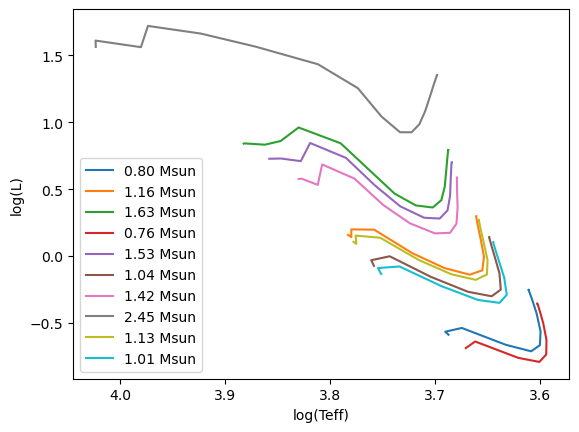

In [ ]:
masses = salpeter_imf(0.7, 2.5, 10)

run_mesa_model(masses)

plot_hr_diagram(masses)

## NGC 4755

FOR MASS: 0.9988630409976494
/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
partC.ipynb
report.tex
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:24:01
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.622443   4380.723  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.8416E+00   6.622443   0.265939 -99.000000  -6.324530 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071831      2
 3.6400E-05   0.145279   0.052756 -99.000000 -99.000000  -6.814988   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.622443   4380.724  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.7625E+00   6.622443   0.265939 -99.000000  -6.324530 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071831      3
 5.3680E-05   0.145279   0.052756 -99.000000 -99.000000  -6.814988   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.622443   4380.725  -4.926778  -4.926778   0.998863   0.998863   0.700000   0.001010   0.280000  -4.062049    698      0
-4.6833E+00   6.622443   0.265939 -99.000000  -6.324530 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:28:32
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.8416E+00   6.631017   0.070113 -99.000000  -6.063847 -99.000000   0.000000   0.280000   0.009381   0.020000   0.095227      2
 3.6400E-05   0.538342  -0.564471 -20.169010 -99.000000  -6.393179   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.7625E+00   6.631017   0.070113 -99.000000  -6.063847 -99.000000   0.000000   0.280000   0.009381   0.020000   0.095227      2
 5.3680E-05   0.538342  -0.564471 -19.867980 -99.000000  -6.393179   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.631017   3847.268  -4.666265  -4.666265   0.646358   0.646358   0.700000   0.001010   0.280000  -3.178162    701      0
-4.6833E+00   6.631017   0.070113 -99.000000  -6.063847 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:34:27
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.614502   4516.711  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.8416E+00   6.614502   0.318164 -99.000000  -6.447762 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067126      2
 3.6400E-05   0.033187   0.210311 -20.771070 -99.000000  -6.901293   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.614502   4516.701  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.7625E+00   6.614502   0.318164 -99.000000  -6.447762 -99.000000   0.000000   0.280000   0.009381   0.020000   0.067126      2
 5.3680E-05   0.033187   0.210307 -20.771070 -99.000000  -6.901290   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.614502   4516.691  -5.049984  -5.049984   1.105709   1.105709   0.700000   0.001010   0.280000  -4.293946    698      0
-4.6833E+00   6.614502   0.318164 -99.000000  -6.447762 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-07
TIME: 23:40:12
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.608056   4402.017  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.8416E+00   6.608056   0.284275 -99.000000  -6.481914 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071207      3
 3.6400E-05   0.090747   0.097850 -20.771070 -99.000000  -6.844763   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.608056   4402.008  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.7625E+00   6.608056   0.284275 -99.000000  -6.481914 -99.000000   0.000000   0.280000   0.009381   0.020000   0.071207      3
 5.3680E-05   0.090747   0.097846 -20.293948 -99.000000  -6.844759   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.608056   4401.996  -5.084150  -5.084150   1.003776   1.003776   0.700000   0.001010   0.280000  -4.138343    708      0
-4.6833E+00   6.608056   0.284275 -99.000000  -6.481914 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:15:39
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.8416E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105614      2
 3.6400E-05   0.733897  -0.791470 -99.000000 -99.000000  -6.271971   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.7625E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.000000   0.000000   0.280000   0.009381   0.020000   0.105614      2
 5.3680E-05   0.733897  -0.791470 -20.169010 -99.000000  -6.271971   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.651240   3734.337  -4.397464  -4.397464   0.554634   0.554634   0.700000   0.001010   0.280000  -2.791013    712      0
-4.6833E+00   6.651240  -0.017509 -99.000000  -5.794893 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:20:58
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.8416E+00   6.635424   0.089063 -99.000000  -6.037344 -99.000000   0.000000   0.280000   0.009381   0.020000   0.092057      2
 3.6400E-05   0.507467  -0.506713 -99.000000 -99.000000  -6.427697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.7625E+00   6.635424   0.089063 -99.000000  -6.037344 -99.000000   0.000000   0.280000   0.009381   0.020000   0.092057      2
 5.3680E-05   0.507467  -0.506713 -99.000000 -99.000000  -6.427697   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.635424   3891.497  -4.639740  -4.639740   0.683762   0.683762   0.700000   0.001010   0.280000  -3.265682    706      0
-4.6833E+00   6.635424   0.089063 -99.000000  -6.037344 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:25:11
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.8416E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.000000   0.000000   0.280000   0.009381   0.020000   0.103888      2
 3.6400E-05   0.717310  -0.766247 -20.169010 -99.000000  -6.286016   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.7625E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.000000   0.000000   0.280000   0.009381   0.020000   0.103888      2
 5.3680E-05   0.717310  -0.766247 -99.000000 -99.000000  -6.286016   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.652867   3746.052  -4.389159  -4.389159   0.570339   0.570339   0.700000   0.001010   0.280000  -2.835743    713      0
-4.6833E+00   6.652867  -0.007618 -99.000000  -5.786606 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:30:37
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.639902   3772.585  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.8416E+00   6.639902   0.021088 -99.000000  -5.936069 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101234      2
 3.6400E-05   0.644700  -0.696574 -20.470040 -99.000000  -6.321344   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.639902   3772.585  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.7625E+00   6.639902   0.021088 -99.000000  -5.936069 -99.000000   0.000000   0.280000   0.009381   0.020000   0.101234      2
 5.3680E-05   0.644700  -0.696574 -19.992918 -99.000000  -6.321344   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.639902   3772.584  -4.538563  -4.538563   0.589582   0.589582   0.700000   0.001010   0.280000  -2.960491    709      0
-4.6833E+00   6.639902   0.021088 -99.000000  -5.936069 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:36:54
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.626071   3975.300  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.8416E+00   6.626071   0.133048 -99.000000  -6.166874 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087260      2
 3.6400E-05   0.409672  -0.381731 -99.000000 -99.000000  -6.514633   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.626071   3975.301  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.7625E+00   6.626071   0.133048 -99.000000  -6.166874 -99.000000   0.000000   0.280000   0.009381   0.020000   0.087260      2
 5.3680E-05   0.409672  -0.381731 -20.169010 -99.000000  -6.514633   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.626071   3975.300  -4.769219  -4.769219   0.739549   0.739549   0.700000   0.001010   0.280000  -3.460882    704      0
-4.6833E+00   6.626071   0.133048 -99.000000  -6.166874 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-04-08
TIME: 00:42:49
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.8416E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.000000   0.000000   0.280000   0.009381   0.020000   0.111830      2
 3.6400E-05   0.838365  -0.896253 -99.000000 -99.000000  -6.190786   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.7625E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.000000   0.000000   0.280000   0.009381   0.020000   0.111830      2
 5.3680E-05   0.838365  -0.896253 -99.000000 -99.000000  -6.190786   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   6.661225   3715.507  -4.265369  -4.265369   0.508053   0.508053   0.700000   0.001010   0.280000  -2.580083    714      0
-4.6833E+00   6.661225  -0.065510 -99.000000  -5.662683 -99.

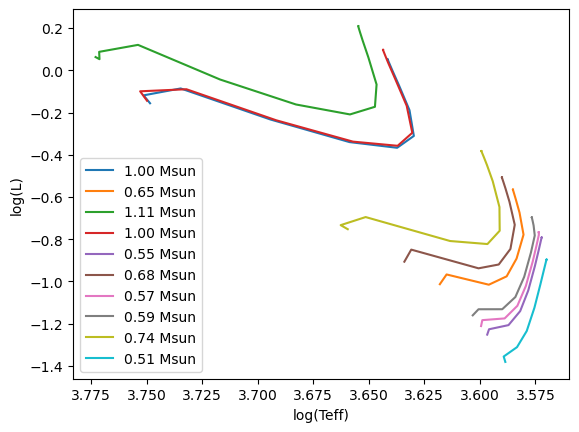

In [8]:
masses = salpeter_imf(0.5, 20, 10) # 100 stars

run_mesa_model(masses)

plot_hr_diagram(masses)

## Blanco 1 Open Cluster

In [ ]:
masses = salpeter_imf(0.2, 8, 10) # 644 stars

run_mesa_model(masses)

plot_hr_diagram(masses)